# Lecture 23: Deep Learning with Keras

This lecture is meant to get you started in using Keras to design Deep Neural Networks. We'll use the same data we have used in lecture and labs until now.

Let's start with reading the data, like before:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))

filename="../Lecture.16/SUSY.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

Now lets define training and test samples. Note that DNNs take very long to train, so for testing purposes we will use only about 10% of the 5 million events in the training/validation sample. Once you get everything working, make the final version of your plots with the full sample. 

Also note that Keras had trouble with the Pandas tensors, so after doing all of the nice manipulation that Pandas enables, we convert the Tensor to a regular numpy tensor.

In [2]:
N_Max=550000
N_Train=500000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:N_Max]

X_Train=np.array(Train_Sample[VarNames[1:]])
y_Train=np.array(Train_Sample["signal"])

X_Test=np.array(Test_Sample[VarNames[1:]])
y_Test=np.array(Test_Sample["signal"])


Now we will build a simple model, as described in class. Note that this is very small model, so things run fast. You should attempt more ambitious models.

In most Deep Learning frameworks, models are build layer by layer. In Keras, you can make simple models using  `Sequential`. This method is now mostly discouraged, but it still works and is illustrative:

In [5]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=X_Train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
X_Train.shape[1]

18

Lets quickly compute the number of parameters we expect in our model:

In [7]:
18*12 + 12

228

In [8]:
12 * 8 + 8

104

In [9]:
8 * 8 + 8

72

You can have Keras print out the model for you to investigate:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                228       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


The preferred method of creating a model is to use functional API, where the Deep Neural Network is viewed as a composition of functions. With this API, you can create very sophisticated models with multiple inputs and outputs.

In [12]:
from keras.models import Model
from keras.layers import Dense, Input

in_x = Input(shape = X_Train.shape[1:])
x = Dense(12, input_dim=X_Train.shape[1], activation='relu')(in_x)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
out_x = Dense(1, activation='sigmoid')(x)

model = Model(in_x,out_x)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


Few things to notice:
* Activations can be specified here, but can be added as their own layers.
* Note that in most cases where you are using existing Keras components with their default configuration, you can just specify the object you want by name. If you want to change a default, you'll have to create an instance of the object.



In [19]:
from keras.activations import relu

in_x = Input(shape = X_Train.shape[1:])
x = Dense(12, input_dim=X_Train.shape[1], activation='relu')(in_x)
x = Dense(8)(x)
x = relu(x)
out_x = Dense(1, activation='sigmoid')(x)

model = Model(in_x,out_x)

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 12)                228       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 104       
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 8)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


Once the DNN has been specified, we will have to further forumlate our problem by specifing the loss (the parameter which will be optimized during training), and the optimizer (the optimization algorithm). In Keras, these are specified at "compile" time:

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Note that we also specified a metric which Keras will compute for us during training so we can keep track of the progress of training. 

Few things to define and be aware of before we train:

* An epoch is defined as one training pass using the whole training data.
* Epochs are broken into smaller steps. At each step a subset of the training data, referred to as a batch, is used to compute the gradients perform an optimization step. Taking many steps is an example of stochastic gradient decent, is an important ingredient to getting Deep Learning working.
* In order to monitor the training process, we typically compare the performance on the training sample and another sample (validation sample in Keras).

The easiest way to train is to use the `fit` method:

In [21]:
history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=10, batch_size=2048)

Epoch 1/10
245/245 [==============================] - 1s 3ms/step - loss: 0.6526 - accuracy: 0.6311 - val_loss: 0.4749 - val_accuracy: 0.7791
Epoch 2/10
245/245 [==============================] - 1s 2ms/step - loss: 0.4637 - accuracy: 0.7864 - val_loss: 0.4564 - val_accuracy: 0.7882
Epoch 3/10
245/245 [==============================] - 1s 2ms/step - loss: 0.4505 - accuracy: 0.7929 - val_loss: 0.4502 - val_accuracy: 0.7918
Epoch 4/10
245/245 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.7960 - val_loss: 0.4468 - val_accuracy: 0.7937
Epoch 5/10
245/245 [==============================] - 1s 3ms/step - loss: 0.4423 - accuracy: 0.7964 - val_loss: 0.4434 - val_accuracy: 0.7948
Epoch 6/10
245/245 [==============================] - 1s 2ms/step - loss: 0.4388 - accuracy: 0.7981 - val_loss: 0.4415 - val_accuracy: 0.7958
Epoch 7/10
245/245 [==============================] - 1s 2ms/step - loss: 0.4382 - accuracy: 0.7983 - val_loss: 0.4410 - val_accuracy: 0.7959
Epoch 

Note that `fit` takes care of

* Running multiple epochs
* Dividing the data into batches
* Computing gradient on each batch
* Using optimizer to take step
* Evaluating performance on training and testing data
* Keep track of everything

But in some instances you may wish to consume data from a difference source (rather than a tensor in memory) or do something different (e.g. training an Adversarial network), which will require you to perform some of these steps yourself. Keras provides easy methods to enable such functionality.

The model history keeps track of the loss and accuracy for each epoch. Note that the training above was setup to run on the validation sample at the end of each epoch:

In [22]:
print (history.history)

{'loss': [0.5716032981872559, 0.4593602120876312, 0.4493780732154846, 0.44435060024261475, 0.44140928983688354, 0.4393320083618164, 0.43801501393318176, 0.4369085729122162, 0.43618956208229065, 0.43615105748176575], 'accuracy': [0.7064800262451172, 0.788428008556366, 0.7936059832572937, 0.7955719828605652, 0.7966780066490173, 0.7975580096244812, 0.7981340289115906, 0.7986159920692444, 0.798878014087677, 0.7989519834518433], 'val_loss': [0.47489553689956665, 0.45642417669296265, 0.4502257704734802, 0.4468110203742981, 0.4434027075767517, 0.4415314197540283, 0.440996378660202, 0.43966051936149597, 0.4392298460006714, 0.43873879313468933], 'val_accuracy': [0.7791200280189514, 0.7881600260734558, 0.7917799949645996, 0.793720006942749, 0.79475998878479, 0.7958199977874756, 0.7959200143814087, 0.7964800000190735, 0.7964199781417847, 0.7973600029945374]}


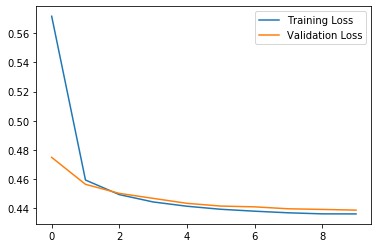

In [23]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

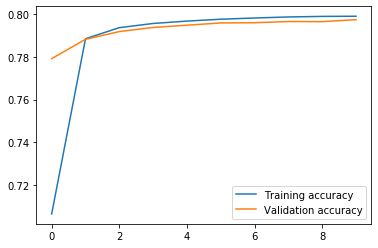

In [24]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation accuracy")
plt.legend()

We can evaluate how the trained model does on the test sample as follows:

In [25]:
scores = model.evaluate(X_Test, y_Test)
print(scores)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.4387 - accuracy: 0.7974
[0.43873894214630127, 0.7973600029945374]


While evaluate is useful for assessing performance, once you have trained a model and determined you with to use it, you will want to apply to data without ground truth or the known desired output (in this case signal or background). `predict` enables this functionality:

In [26]:
model.predict(X_Test)

array([[0.80140465],
       [0.14015812],
       [0.11646995],
       ...,
       [0.5131845 ],
       [0.31018984],
       [0.15322334]], dtype=float32)

Note the output here is a number between 0 and 1. Determining what threshold to use to select signal is analgous to what we did for other ML methods.

And we can make ROC curves as before:

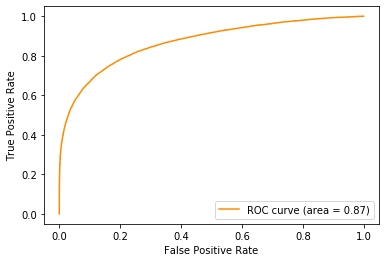

In [27]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()